# Shipwell Data Science Test

Problem:
Build a method (unsupervised or supervised) that classifies malformed shipments, according to whether they have incorrect data, missing data, or abnormal from typical shipments in other ways, etc.

Hypothesis:
*    It is expected that missing values, NaN values, and incorrect data will show up in a cluster group.
*    The unsupervised modeling will work by grouping those rows with the above instances, due to their similarity.
*    The model can be assessed by evaluating the within group sum of squares to the between group sum of sqaures.
*    An ideal ratio would be a tight WGSS and a broad BGSS that will be evident of an accurate anomaly detection.

Import Libraries

In [243]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn import preprocessing
warnings.filterwarnings("ignore")
import matplotlib.dates as md
import pandas as pd
import numpy as np 
import seaborn
import warnings

# Data Cleaning and Discovery

Read in the data

In [244]:
df = pd.read_csv('/Users/MatthewPrzybyla/Downloads/ShipmentData.csv')

Convert the dates to the datetime format for standaradization and modeling

In [245]:
df['Shipment Pickup Stop Planned Date'] = pd.to_datetime(df['Shipment Pickup Stop Planned Date'])
df['Shipment Pickup ETA Initial Window Start Date'] = pd.to_datetime(df['Shipment Pickup ETA Initial Window Start Date'])
df['Shipment Pickup ETA Initial Window End Date'] = pd.to_datetime(df['Shipment Pickup ETA Initial Window End Date'])
df['Shipment Pickup Stop Planned Date'] = pd.to_datetime(df['Shipment Pickup Stop Planned Date'])
df['Shipment Pickup Stop Completed Date'] = pd.to_datetime(df['Shipment Pickup Stop Completed Date'])
df['Shipment Drop-Off ETA Initial Window End Date'] = pd.to_datetime(df[ 'Shipment Drop-Off ETA Initial Window End Date'])
df['Shipment Pickup ETA Initial Window End Date'] = pd.to_datetime(df['Shipment Pickup ETA Initial Window End Date'])
df['Shipment Drop-Off Stop Planned Date'] = pd.to_datetime(df['Shipment Drop-Off Stop Planned Date'])
df['Shipment Drop-Off Stop Completed Date'] = pd.to_datetime(df['Shipment Drop-Off Stop Completed Date'])
df['Shipment Pickup ETA Overridden Initial Window End Date'] = pd.to_datetime(df['Shipment Pickup ETA Overridden Initial Window End Date'])
df['Shipment Drop-Off ETA Overridden Initial Window End Date'] = pd.to_datetime(df['Shipment Drop-Off ETA Overridden Initial Window End Date'])
df['Timeline Event Occurred Time'] = pd.to_datetime(df['Timeline Event Occurred Time'])

List out the columns to get a sense of the data

In [246]:
list(df)

['Number',
 'Shipments Reference ID',
 'Vendor Name',
 'Shipment Mode Code',
 'Shipment Pickup ETA Initial Window Start Date',
 'Shipment Pickup ETA Initial Window End Date',
 'Shipment Pickup Stop Planned Date',
 'Shipment Pickup Stop Completed Date',
 'Shipment Quote Transit Days',
 'Shipment Drop-Off ETA Initial Window End Date',
 'Shipment Drop-Off Stop Planned Date',
 'Shipment Drop-Off Stop Completed Date',
 'Shipment Pickup ETA Overridden Initial Window End Date',
 'Shipment Drop-Off ETA Overridden Initial Window End Date',
 'Timeline Event Occurred Time',
 'Timeline Event Event Type',
 'Timeline Event Event Sub Type',
 'Timeline Event Description',
 'Current Address Has Location Data (Yes / No)',
 'Shipment Mode Description',
 'Shipments Weight Lbs',
 'Shipments Purchase Order Number',
 'Shipments Pro Number',
 'Shipments Pickup Number',
 'Shipments Notes for Carrier',
 'Shipments External Tracking JSON',
 'Shipments Tracked with Location Data']

Dimensions of the data

In [247]:
df.shape

(3915, 27)

Standardize the values that are numerical

In [249]:
# Copy the original dataset
scaled_features = df.copy()

# Extract column names to be standardized
col_names = ['Shipment Quote Transit Days','Shipments Weight Lbs', 'Shipments Tracked with Location Data']

# Standardize the columns and re-assingn to original dataframe
features = scaled_features[col_names]
scaler = RobustScaler().fit_transform(features.values)
features = pd.DataFrame(scaler, index=df.index, columns=col_names)
scaled_features [col_names] = features
scaled_features.head()

,Number,Shipments Reference ID,Vendor Name,Shipment Mode Code,Shipment Pickup ETA Initial Window Start Date,Shipment Pickup ETA Initial Window End Date,Shipment Pickup Stop Planned Date,Shipment Pickup Stop Completed Date,Shipment Quote Transit Days,Shipment Drop-Off ETA Initial Window End Date,...,Timeline Event Description,Current Address Has Location Data (Yes / No),Shipment Mode Description,Shipments Weight Lbs,Shipments Purchase Order Number,Shipments Pro Number,Shipments Pickup Number,Shipments Notes for Carrier,Shipments External Tracking JSON,Shipments Tracked with Location Data
0,1,XSAM5D,K A T TRANSPORT LLC,FTL,NaT,NaT,2018-07-06,2018-07-06,NaN,NaT,...,NICKK - Tracking email sent,No,Full Truckload,NaN,NaN,XSAM5D,NaN,NaN,NaN,0.0
1,2,XSAM5D,K A T TRANSPORT LLC,FTL,NaT,NaT,2018-07-06,2018-07-06,NaN,NaT,...,Per dispatch - at delivery location,No,Full Truckload,NaN,NaN,XSAM5D,NaN,NaN,NaN,0.0
2,3,XRBPNL,JASVIR SINGH,FTL,NaT,NaT,2018-07-23,NaT,NaN,NaT,...,PICKUP ETA REQUEST SENT,No,Full Truckload,NaN,NaN,XRBPNL,NaN,NaN,NaN,0.0
3,4,XRBPNL,JASVIR SINGH,FTL,NaT,NaT,2018-07-23,NaT,NaN,NaT,...,IN TRANSIT TRACK REQUEST SENT,No,Full Truckload,NaN,NaN,XRBPNL,NaN,NaN,NaN,0.0
4,5,XRBPNL,JASVIR SINGH,FTL,NaT,NaT,2018-07-23,NaT,NaN,NaT,...,NICKK - Tracking email sent,No,Full Truckload,NaN,NaN,XRBPNL,NaN,NaN,NaN,0.0


Check for NaN/null/missing values

In [250]:
df2 = pd.DataFrame(df.isnull().any())

In [251]:
df2.head()

,0
Number,False
Shipments Reference ID,False
Vendor Name,False
Shipment Mode Code,False
Shipment Pickup ETA Initial Window Start Date,True


Fill NaN values with 0 to be able to process for this specific modeling 

In [252]:
df = df.fillna(0)

Double check if missing values exist

In [253]:
df.columns[df.isnull().any()].tolist()

[]

Drop these 2 columns because they are not essential in clustering algorithm
* They will be used eventually for NLP Analysis and Topic Modeling

In [254]:
df = df.drop(['Timeline Event Description','Shipment Mode Description'], axis =1)

Investigate the types of attributes

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Data columns (total 25 columns):
Number                                                      3915 non-null int64
Shipments Reference ID                                      3915 non-null object
Vendor Name                                                 3915 non-null object
Shipment Mode Code                                          3915 non-null object
Shipment Pickup ETA Initial Window Start Date               3915 non-null datetime64[ns]
Shipment Pickup ETA Initial Window End Date                 3915 non-null datetime64[ns]
Shipment Pickup Stop Planned Date                           3915 non-null datetime64[ns]
Shipment Pickup Stop Completed Date                         3915 non-null datetime64[ns]
Shipment Quote Transit Days                                 3915 non-null float64
Shipment Drop-Off ETA Initial Window End Date               3915 non-null datetime64[ns]
Shipment Drop-Off Stop Planned Date        

For the categorical data, create dummy variables so that the model can process them correctly

In [256]:
colsDummy = ['Vendor Name', 'Shipment Mode Code', 'Timeline Event Event Type',
            'Timeline Event Event Sub Type', 
            'Current Address Has Location Data (Yes / No)',
            'Shipments Purchase Order Number', 'Shipments Pro Number', 'Shipments Pickup Number',
            'Shipments Notes for Carrier', 'Shipments Tracked with Location Data']
df = pd.get_dummies( df,columns = colsDummy )
df.head()

,Number,Shipments Reference ID,Shipment Pickup ETA Initial Window Start Date,Shipment Pickup ETA Initial Window End Date,Shipment Pickup Stop Planned Date,Shipment Pickup Stop Completed Date,Shipment Quote Transit Days,Shipment Drop-Off ETA Initial Window End Date,Shipment Drop-Off Stop Planned Date,Shipment Drop-Off Stop Completed Date,...,Shipments Notes for Carrier_PO# 117512 (315),Shipments Notes for Carrier_PO#117518,Shipments Notes for Carrier_PRIORITY COLLECT,Shipments Notes for Carrier_Referance Number 751174,Shipments Notes for Carrier_Shipment # RZ2G54 MUST--schedule Delivery APPOINTMENT 24 hours prior to delivery--,Shipments Notes for Carrier_Shipment #HA44T3 Delivery Appointment MUST be scheduled 24 hours in advance.,Shipments Notes for Carrier_Spacemax / Catalyst Delivery: Full dock height/receiving back right side of building,Shipments Notes for Carrier_THE RECIEVER REQUIRES A PHONE CALL TO MAKE SPECIFIC DELIVERY ARRANGEMENTS**,Shipments Tracked with Location Data_0,Shipments Tracked with Location Data_1
0,1,XSAM5D,1970-01-01,1970-01-01,2018-07-06,2018-07-06,0.0,1970-01-01,2018-07-09,2018-07-09,...,0,0,0,0,0,0,0,0,1,0
1,2,XSAM5D,1970-01-01,1970-01-01,2018-07-06,2018-07-06,0.0,1970-01-01,2018-07-09,2018-07-09,...,0,0,0,0,0,0,0,0,1,0
2,3,XRBPNL,1970-01-01,1970-01-01,2018-07-23,1970-01-01,0.0,1970-01-01,2018-07-25,2018-07-25,...,0,0,0,0,0,0,0,0,1,0
3,4,XRBPNL,1970-01-01,1970-01-01,2018-07-23,1970-01-01,0.0,1970-01-01,2018-07-25,2018-07-25,...,0,0,0,0,0,0,0,0,1,0
4,5,XRBPNL,1970-01-01,1970-01-01,2018-07-23,1970-01-01,0.0,1970-01-01,2018-07-25,2018-07-25,...,0,0,0,0,0,0,0,0,1,0


In [257]:
df.head()

,Number,Shipments Reference ID,Shipment Pickup ETA Initial Window Start Date,Shipment Pickup ETA Initial Window End Date,Shipment Pickup Stop Planned Date,Shipment Pickup Stop Completed Date,Shipment Quote Transit Days,Shipment Drop-Off ETA Initial Window End Date,Shipment Drop-Off Stop Planned Date,Shipment Drop-Off Stop Completed Date,...,Shipments Notes for Carrier_PO# 117512 (315),Shipments Notes for Carrier_PO#117518,Shipments Notes for Carrier_PRIORITY COLLECT,Shipments Notes for Carrier_Referance Number 751174,Shipments Notes for Carrier_Shipment # RZ2G54 MUST--schedule Delivery APPOINTMENT 24 hours prior to delivery--,Shipments Notes for Carrier_Shipment #HA44T3 Delivery Appointment MUST be scheduled 24 hours in advance.,Shipments Notes for Carrier_Spacemax / Catalyst Delivery: Full dock height/receiving back right side of building,Shipments Notes for Carrier_THE RECIEVER REQUIRES A PHONE CALL TO MAKE SPECIFIC DELIVERY ARRANGEMENTS**,Shipments Tracked with Location Data_0,Shipments Tracked with Location Data_1
0,1,XSAM5D,1970-01-01,1970-01-01,2018-07-06,2018-07-06,0.0,1970-01-01,2018-07-09,2018-07-09,...,0,0,0,0,0,0,0,0,1,0
1,2,XSAM5D,1970-01-01,1970-01-01,2018-07-06,2018-07-06,0.0,1970-01-01,2018-07-09,2018-07-09,...,0,0,0,0,0,0,0,0,1,0
2,3,XRBPNL,1970-01-01,1970-01-01,2018-07-23,1970-01-01,0.0,1970-01-01,2018-07-25,2018-07-25,...,0,0,0,0,0,0,0,0,1,0
3,4,XRBPNL,1970-01-01,1970-01-01,2018-07-23,1970-01-01,0.0,1970-01-01,2018-07-25,2018-07-25,...,0,0,0,0,0,0,0,0,1,0
4,5,XRBPNL,1970-01-01,1970-01-01,2018-07-23,1970-01-01,0.0,1970-01-01,2018-07-25,2018-07-25,...,0,0,0,0,0,0,0,0,1,0


In [258]:
df3 = pd.DataFrame(df.notnull().any())
df3.head()

,0
Number,True
Shipments Reference ID,True
Shipment Pickup ETA Initial Window Start Date,True
Shipment Pickup ETA Initial Window End Date,True
Shipment Pickup Stop Planned Date,True


In [259]:
df = df.drop(['Shipments Reference ID'], axis =1)

In [260]:
df = df.drop(['Shipments External Tracking JSON'], axis =1)

In [261]:
df = df.drop(['Shipment Pickup ETA Initial Window Start Date',
 'Shipment Pickup ETA Initial Window End Date',
 'Shipment Pickup Stop Planned Date',
 'Shipment Pickup Stop Completed Date',
 'Shipment Drop-Off ETA Initial Window End Date',
 'Shipment Drop-Off Stop Planned Date',
 'Shipment Drop-Off Stop Completed Date',
 'Shipment Pickup ETA Overridden Initial Window End Date',
 'Shipment Drop-Off ETA Overridden Initial Window End Date',
 'Timeline Event Occurred Time'], axis =1)

In [262]:
list(df)

['Number',
 'Shipment Quote Transit Days',
 'Shipments Weight Lbs',
 'Vendor Name_1SOURCE TRANSPORTATION LLC',
 'Vendor Name_3D LOGISTICS INC',
 'Vendor Name_A J T TRUCKING INC',
 'Vendor Name_A VARGAS LOGISTICS LLC',
 'Vendor Name_A. Duie Pyle',
 'Vendor Name_AAA Cooper Transportation',
 'Vendor Name_ABF Freight',
 'Vendor Name_AFIDUS LOGISTICS LLC',
 'Vendor Name_ALLSTATE EXPRESS OF IL INC',
 'Vendor Name_AMERICA 1 LOGISTICS LLC',
 'Vendor Name_AMERISPEED LLC',
 'Vendor Name_AMF LOGISTICS LLC',
 'Vendor Name_ANDREX LOGISTICS INC',
 'Vendor Name_APT TRANSPORT INC',
 'Vendor Name_AQIDA TRANS LLC',
 'Vendor Name_ARY TRANSPORT SERVICES INC',
 'Vendor Name_ASAP TRANS CORP',
 'Vendor Name_BEN TRANSPORTATION LLC',
 'Vendor Name_BHUPINDER S GILL',
 'Vendor Name_BLACKFISH ENTERPRISE',
 'Vendor Name_BMM TRANSPORTATION INC',
 'Vendor Name_BORDEN TRUCKING LLC',
 'Vendor Name_C A C INTERNATIONAL LLC',
 'Vendor Name_CADDO MILLS FREIGHT LLC',
 'Vendor Name_CARDINAL LOGISTICS MANAGEMENT CORPORATION'

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Columns: 1283 entries, Number to Shipments Tracked with Location Data_1
dtypes: float64(2), int64(1), uint8(1280)
memory usage: 4.9 MB


In [264]:
df.describe()

,Number,Shipment Quote Transit Days,Shipments Weight Lbs,Vendor Name_1SOURCE TRANSPORTATION LLC,Vendor Name_3D LOGISTICS INC,Vendor Name_A J T TRUCKING INC,Vendor Name_A VARGAS LOGISTICS LLC,Vendor Name_A. Duie Pyle,Vendor Name_AAA Cooper Transportation,Vendor Name_ABF Freight,...,Shipments Notes for Carrier_PO# 117512 (315),Shipments Notes for Carrier_PO#117518,Shipments Notes for Carrier_PRIORITY COLLECT,Shipments Notes for Carrier_Referance Number 751174,Shipments Notes for Carrier_Shipment # RZ2G54 MUST--schedule Delivery APPOINTMENT 24 hours prior to delivery--,Shipments Notes for Carrier_Shipment #HA44T3 Delivery Appointment MUST be scheduled 24 hours in advance.,Shipments Notes for Carrier_Spacemax / Catalyst Delivery: Full dock height/receiving back right side of building,Shipments Notes for Carrier_THE RECIEVER REQUIRES A PHONE CALL TO MAKE SPECIFIC DELIVERY ARRANGEMENTS**,Shipments Tracked with Location Data_0,Shipments Tracked with Location Data_1
count,3915.00000,3915.00000,3915.0,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,...,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000
mean,1958.00000,2.52567,0.0,0.000766,0.001788,0.001022,0.000511,0.024521,0.050319,0.016092,...,0.005364,0.004598,0.003831,0.003321,0.000255,0.000511,0.006386,0.003831,0.921839,0.078161
std,1130.30748,1.90434,0.0,0.027675,0.042252,0.031952,0.022599,0.154680,0.218631,0.125845,...,0.073052,0.067659,0.061788,0.057536,0.015982,0.022599,0.079665,0.061788,0.268459,0.268459
min,1.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,979.50000,1.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1958.00000,2.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2936.50000,4.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3915.00000,8.00000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Initiate Unsupervised Clustering Model

Scale and use PCA for dimentionality reduction due to large dataset with mutliple columns

In [265]:
data = df
#df[['Shipment Quote Transit Days', 'Shipments Weight Lbs',
#          'Shipments Tracked with Location Data'
#Shipment Pickup ETA Initial Window End Date                
#Shipment Pickup Stop Planned Date                          
#Shipment Pickup Stop Completed Date 
#I should convert all the timestamps to 0 or 1
 #         ]]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

Elbow plot to determine the optimal amount of K in K Means. 
    * Where the elbow starts is optimal

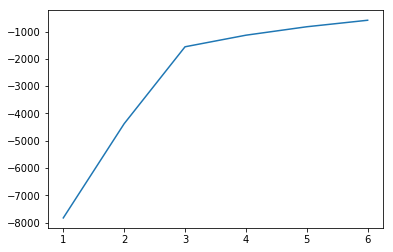

In [266]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 7)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [267]:
df['cluster'] = kmeans[3].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    3309
2     298
3     202
1     106
Name: cluster, dtype: int64

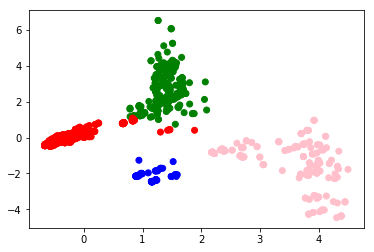

In [268]:
# plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 
          #5:'orange', 
          #6:'cyan', 
          #7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'
         }
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

# Function Creation

In [269]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

# return the success probability of the state change 
def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0,len(transition_matrix)):
        if (k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

# return the success probability of the whole sequence
def sucessScore(sequence, transition_matrix):
    proba = 0 
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba

# return if the sequence is an anomaly considering a threshold
def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1

# return a dataframe containing anomaly result for the whole dataset 
# choosing a sliding windows size (size of sequence to evaluate) and a threshold
def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [270]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [271]:
outliers_fraction = 0.01

Get the distance between each point and its nearest centroid. 
* The biggest distances are considered as an anomaly
* Anomaly21 contain the anomaly result of method 2.1 Cluster (0: normal, 1: anomaly) 

In [272]:
distance = getDistanceByPoint(data, kmeans[5])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

Visualization of anomaly with cluster view 
* red = anomaly
* blue = normal

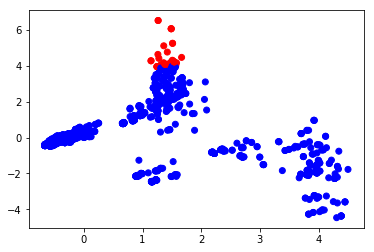

In [273]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [274]:
df.head()

,Number,Shipment Quote Transit Days,Shipments Weight Lbs,Vendor Name_1SOURCE TRANSPORTATION LLC,Vendor Name_3D LOGISTICS INC,Vendor Name_A J T TRUCKING INC,Vendor Name_A VARGAS LOGISTICS LLC,Vendor Name_A. Duie Pyle,Vendor Name_AAA Cooper Transportation,Vendor Name_ABF Freight,...,Shipments Notes for Carrier_Shipment # RZ2G54 MUST--schedule Delivery APPOINTMENT 24 hours prior to delivery--,Shipments Notes for Carrier_Shipment #HA44T3 Delivery Appointment MUST be scheduled 24 hours in advance.,Shipments Notes for Carrier_Spacemax / Catalyst Delivery: Full dock height/receiving back right side of building,Shipments Notes for Carrier_THE RECIEVER REQUIRES A PHONE CALL TO MAKE SPECIFIC DELIVERY ARRANGEMENTS**,Shipments Tracked with Location Data_0,Shipments Tracked with Location Data_1,cluster,principal_feature1,principal_feature2,anomaly21
0,1,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.665919,0.769395,0
1,2,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.665917,0.769402,0
2,3,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.674147,0.781852,0
3,4,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.674144,0.781858,0
4,5,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.674142,0.781865,0


In [275]:
#df.append(df2, ignore_index=True)

In [277]:
# time with int to plot easily
#df['time_epoch'] = (df['Shipment Pickup Stop Planned Date'].astype(np.int64)/100000000000).astype(np.int64)

Visualization of anomaly throughout time

In [278]:
#fig, ax = plt.subplots()

#a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'Shipments Weight Lbs']] #anomaly

#ax.plot(df['time_epoch'], df['Shipments Weight Lbs'], color='blue')
#ax.scatter(a['time_epoch'],a['Shipments Weight Lbs'], color='red')
#plt.show()

The red is considered the anomaly while the blue represents the normal population

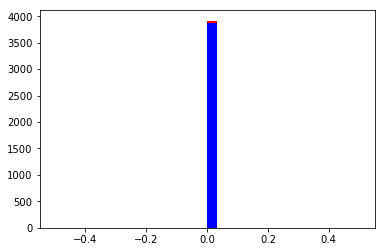

In [279]:
# visualization of anomaly with repartition
a = df.loc[df['anomaly21'] == 0, 'Shipments Weight Lbs']
b = df.loc[df['anomaly21'] == 1, 'Shipments Weight Lbs']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

# Appendix

Code for saving and deploying model

In [280]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model2.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model2.h5")
#print("Saved model to disk")

In [281]:
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

In [282]:
# create the list of difference between prediction and test data
#diff=[]
#ratio=[]
#p = loaded_model.predict(x_test)
#predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
#for u in range(len(y_test)):
#    pr = p[u][0]
#    ratio.append((y_test[u]/pr)-1)
#    diff.append(abs(y_test[u]- pr))

In [283]:
# plot the prediction and the reality (for the test data)
#fig, axs = plt.subplots()
#axs.plot(p,color='red', label='prediction')
#axs.plot(y_test,color='blue', label='y_test')
#plt.legend(loc='upper left')
#plt.show()

# Future Work

I would like to convert all the timestamps as either a row of 0 or 1 and input them in the model which would show that the row is missing a value or not in order to help in deterining a malformed shipment


I would like to apply NLP Topic Modeling for the two description columns

The unsupervised model would then be used for a supervised, classifcation model that would identify the groups that are typically anomaly and apply that to the new test set.